In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from vtk_rw import read_vtk
from plotting import plot_surf_stat_map, crop_img # from https://github.com/juhuntenburg/brainsurfacescripts
import matplotlib as mpl
import cmocean 
from nilearn import plotting
import scipy.stats as stats

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def load_pickle(pkl_file):
    pkl_in = open(pkl_file, 'r')
    pkl_dict = pickle.load(pkl_in)
    pkl_in.close()
    return pkl_dict

### Load data

In [4]:
infl=150
lh_mesh_file = '/nobackup/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_taubin_%i.vtk'%infl
lh_sulc_file = '/nobackup/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_taubin_%i_sulc.npy'%infl
rh_mesh_file = '/nobackup/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_taubin_%i.vtk'%infl
rh_sulc_file = '/nobackup/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_taubin_%i_sulc.npy'%infl
fullmask_file = '/nobackup/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_new.npy'
vizmaks_file = '/nobackup/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_viz.npy'
lh_sulc = np.load(lh_sulc_file)
lv, lf, _ = read_vtk(lh_mesh_file)
rh_sulc = np.load(rh_sulc_file)
rv, rf, _ = read_vtk(rh_mesh_file)
fullmask = np.load(fullmask_file)
vizmask = np.load(vizmaks_file)
figsize_left = (10,9)
figsize_right = (10,7.3)
figsize_dorsal = (10,10)
darkness=0.6

In [6]:
lh_thickness_file = '/nobackup/ilz3/myelinconnect/new_groupavg/thickness/lh_thickness_avg_mm.npy'
rh_thickness_file = '/nobackup/ilz3/myelinconnect/new_groupavg/thickness/rh_thickness_avg_mm.npy'
lh_thickness = np.load(lh_thickness_file)
rh_thickness = np.load(rh_thickness_file)
thickness = np.concatenate((lh_thickness, rh_thickness))
thickness_viz = np.concatenate((lh_thickness, rh_thickness))
thickness_viz[vizmask] = 0

In [7]:
fc_t1 = np.load('/nobackup/ilz3/myelinconnect/new_groupavg/corr/fc_t1_corr.npy')
t1_predict_file_0 = load_pickle('/nobackup/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_0.pkl')

In [8]:
thickness_masked = np.delete(thickness, fullmask)
t1_masked = np.delete(t1_predict_file_0['t1'], fullmask)
embed_masked = np.delete(t1_predict_file_0['modelled_fit'], fullmask)
fc_t1_masked = np.delete(fc_t1, fullmask)

In [10]:
print 'FC/T1 corr vs thickness',stats.pearsonr(fc_t1_masked, thickness_masked)[0]
print 'T1 vs thickness',stats.pearsonr(t1_masked, thickness_masked)[0]
print 'FC1 vs thickness',stats.pearsonr(embed_masked, thickness_masked)[0]

FC/T1 corr vs thickness 0.182466771622
T1 vs thickness 0.625334764582
FC1 vs thickness 0.389050816246


### Plot thickness

In [11]:
def brain_fig(plot_list):
    sns.set_style('white')
    n = len(plot_list)
    rows = int(n/2)
    fig = plt.figure(figsize=(12,rows*5))
    for img in range(n):
        ax = fig.add_subplot(rows,2,img+1)
        plt.imshow(plot_list[img])
        ax.set_axis_off()
    fig.tight_layout()
    return fig

def dorsal_fig(plot_list):
    sns.set_style('white')
    n = len(plot_list)
    rows = int(n/2)
    fig = plt.figure(figsize=(8,rows*10))
    for img in range(n):
        ax = fig.add_subplot(rows,2,img+1)
        plt.imshow(plot_list[img])
        ax.set_axis_off()
    fig.tight_layout()
    return fig

def occ_fig(plot_list):
    sns.set_style('white')
    n = len(plot_list)
    rows = int(n/2)
    fig = plt.figure(figsize=(6,rows*5))
    for img in range(n):
        ax = fig.add_subplot(rows,2,img+1)
        plt.imshow(plot_list[img])
        ax.set_axis_off()
    fig.tight_layout()
    return fig

(array([ 14727.,   3928.,  27083.,  56766.,  37328.,   7999.,   2465.,
           939.,    372.,     91.]),
 array([  5.78312031e-03,   7.87102215e-01,   1.56842131e+00,
          2.34974040e+00,   3.13105950e+00,   3.91237859e+00,
          4.69369769e+00,   5.47501678e+00,   6.25633588e+00,
          7.03765497e+00,   7.81897407e+00]),
 <a list of 10 Patch objects>)

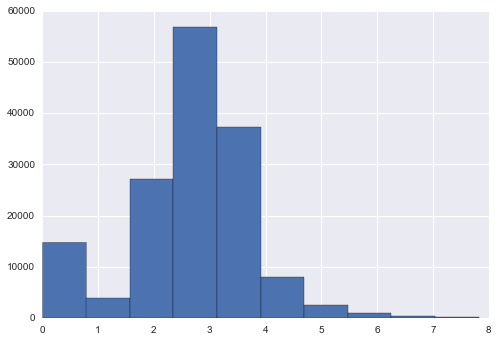

In [13]:
plt.hist(thickness[np.where(thickness!=0)])

In [23]:
sns.set_context(None)
cropped_img = []
vmin=0
vmax=5
data = np.squeeze(thickness_viz)
#cmap=cmocean.cm.matter
cmap=cmocean.cm.amp

sns.set_style('white')
for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], cmap=cmap,
                            bg_map=lh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_left,threshold=1e-50, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))

for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:],  cmap=cmap, 
                            bg_map=rh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_right,threshold=1e-50, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))

for (elev, azim) in [(270, 90)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], cmap=cmap,
                            bg_map=lh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_dorsal,threshold=1e-50, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))


for (elev, azim) in [(270, 90)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], cmap=cmap,
                            bg_map=rh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_dorsal,threshold=1e-50, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))
#(occ, 200, 90)

for (elev, azim) in [(190, 90)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], cmap=cmap,
                            bg_map=lh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_left,threshold=1e-50, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))


for (elev, azim) in [(190, 85)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], cmap=cmap,
                            bg_map=rh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_right,threshold=1e-50, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))

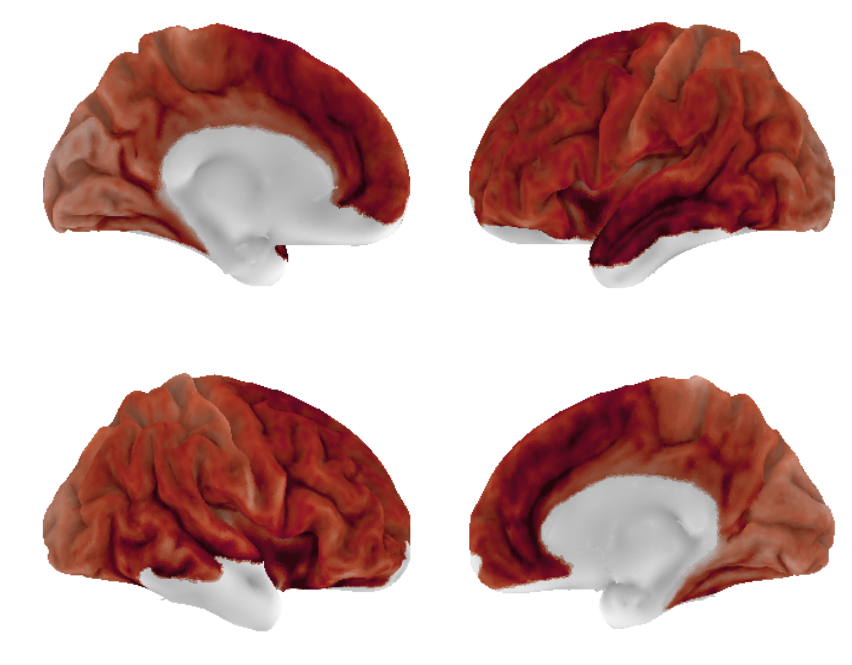

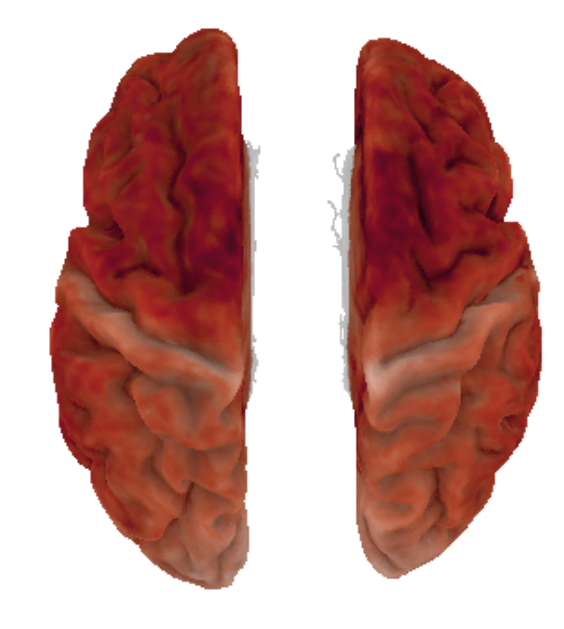

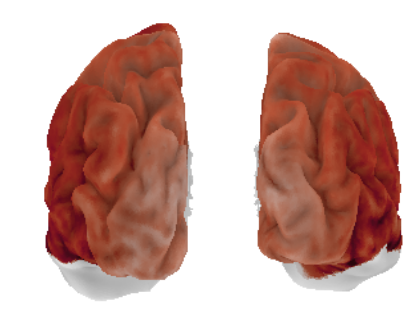

In [28]:
fig=brain_fig(cropped_img[0:4])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/thickness_lat_med.png')
fig = dorsal_fig(cropped_img[4:6])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/thickness_dorsal.png')
fig = occ_fig(cropped_img[6:8])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/thickness_occ.png')

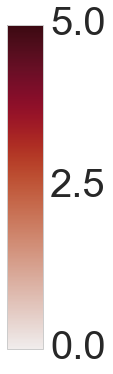

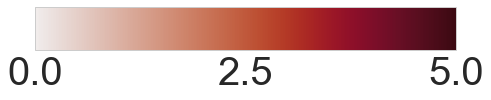

In [27]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=4)
cmap = cmocean.cm.amp
norm = mpl.colors.Normalize(vmin=0, vmax=5)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.05, 0.9])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='vertical', ticks=[0,2.5,5])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/thickness_cbar.svg')

fig = plt.figure(figsize=(6.5, 4))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal', ticks=[0,2.5,5])
fig.savefig('/nobackup/ilz3/myelinconnect/new_groupavg/pics/revisions/thickness_cbar_horizontal.svg')

sns.set()